# Reinforcement Learning Final Project

### Table of Contents

* Imports
* File loading and parsing
* Util functions
* Level 1 (Multi-armed bandit)
* Level 2 (Dynamic programming)
* Level 3 (1-step Sarsa TD with limited statespace)
* Level 4 (1-step Sarsa TD with local window enemy detection)
* Level 5 (1-step Sarsa with local feature statespace)
* Level 6 (n-step semi-gradient Sarsa with neural network function approximation)

In [1]:
# imports for the rest of the assignment
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

# Pytorch for neural network
import torch
from torch import nn
from torch.autograd import backward, Variable
import torch.optim as optim

# animation
import imageio
import os


## Loading Files

In [2]:
# File names
map_1_file = "./data/map_1.dat"
map_2_file = "./data/map_2.dat"
map_3_file = "./data/map_3.dat"
map_4_file = "./data/map_4.dat"

enemies_1_file = "./data/enemies_1.dat"
enemies_2_file = "./data/enemies_2.dat"
enemies_3_file = "./data/enemies_3.dat"

# parse the map files
maps = []
for map_file in [map_1_file, map_2_file, map_3_file, map_4_file]:
    map_data = []
    with open(map_file, 'r') as file:
        for line in file:
            map_data.append(list(map(int, line.split())))
    maps.append(map_data)

# parse all the enemies and 0-index them
enemies = []
for enemies_file in [enemies_1_file, enemies_2_file, enemies_3_file]:
    enemies_data = []
    with open(enemies_file, 'r') as file:
        for line in file:
            ey, ex, et = list(map(int, line.split()))
            enemies_data.append([ey - 1, ex - 1, et])
            
    enemies.append(enemies_data)
print(len(maps[0]), len(maps[0][0]))

# parse the custom map files
# parse the map files
custom_1_file = "./data/layers.dat.txt"
custom = []
for custom_file in [custom_1_file]:
    custom_data = []
    with open(custom_file, 'r') as file:
        for line in file:
            custom_data.append(list((map(int, line.replace("\u200b", " ").split()))))
    custom.append(custom_data[:-1])
      

32 32


## Util functions

### Functions for movement of Hubert and enemies

In [3]:
"""
Algorithm used in weekly task 7 to find intersecting positions
when moving from one grid-based position to the next
"""
def find_intersects(i, j, ni, nj):
    deltai = abs(ni - i)
    deltaj = abs(nj - j)
    n = deltai + deltaj + 1
    di = 1 if ni > i else -1
    dj = 1 if nj > j else -1
    epsilon = deltai - deltaj
    deltai = 2 * deltai
    deltaj = 2 * deltaj
    
    tiles = []
    #find interesects
    while n > 0:
        tiles.append((i, j))
        # The difference in x direction is greater than y
        if epsilon > 0:
            i += di
            epsilon -= deltaj
            n -= 1
        # y difference greater than x
        elif epsilon < 0:
            j += dj
            epsilon += deltai
            n -= 1
        # equal difference in x and y
        elif epsilon == 0:
            i += di
            j += dj
            epsilon += deltai - deltaj
            n -= 2
        
    return tiles


In [4]:
"""
Function defining the logic of moving from one state
to another based on the action taken, without double-jump.
"""
def next_state(x, y, action, level):
    energy = 0
    # jump
    if action == 1:
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if still air under
            if level[y+1][x] == 1:
                y += 1
            
        # if footing is solid
        else:
            # if not solid above
            if level[y-1][x] != 2:
                y -= 1
                # if still not solid above
                if level[y-1][x] != 2:
                    y -= 1
            
            energy = -5
            
    # go left if not solid
    elif action == 0:
        energy = -1
        if level[y][x-1] != 2:
            x -= 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x-1] != 2:
                    x -= 1
                if level[y+1][x] == 1:
                    y += 1
    
    # go right if not solid
    elif action == 2:
        energy = -1
        if level[y][x+1] != 2:
            x += 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x+1] != 2:
                    x += 1
                if level[y+1][x] == 1:
                    y += 1
    
    return ((x, y), energy)
            

In [5]:
"""
Function defining the logic of moving from one state
to another based on the action taken, with double-jump.
"""
def next_state_with_jump(x, y, action, level):
    energy = 0
    # jump
    if action == 1:
        if level[y+1][x] == 1:
            # if footing is air
            if random.randrange(0, 3) == 0:
                if level[y-1][x] != 2:
                    y -= 1
                energy = -3
            else:
                y += 1
                # if still air under
                if level[y+1][x] == 1:
                    y += 1
            
        # if footing is solid
        else:
            # if not solid above
            if level[y-1][x] != 2:
                y -= 1
                # if still not solid above
                if level[y-1][x] != 2:
                    y -= 1
            
            energy = -5
            
    # go left if not solid
    elif action == 0:
        energy = -1
        if level[y][x-1] != 2:
            x -= 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x-1] != 2:
                    x -= 1
                if level[y+1][x] == 1:
                    y += 1
    
    # go right if not solid
    elif action == 2:
        energy = -1
        if level[y][x+1] != 2:
            x += 1
        # if footing is air
        if level[y+1][x] == 1:
            y += 1
            # if footing still air move again and fall
            if level[y+1][x] == 1:
                if level[y][x+1] != 2:
                    x += 1
                if level[y+1][x] == 1:
                    y += 1
    
    return ((x, y), energy)

In [6]:
"""
Function that moves the middle managers to their
next state, randomly chosen between possible actions.
"""
def mms_next_state(mms, level):
    new_mms = []
    if not mms:
        raise ValueError("The list of mms is empty")
    for mmy, mmx in mms:
        options = []
        if level[mmy][mmx-1] != 2 and level[mmy+1][mmx-1] != 1:
            options.append(mmx-1)
        if level[mmy][mmx+1] != 2 and level[mmy+1][mmx+1] != 1:
            options.append(mmx+1)
        
        if not options:
            new_mms.append((mmy, mmx))
        else:
            new_mms.append((mmy, np.random.choice(options)))
    return new_mms


In [7]:
"""
Function that moves the fans to their next state,
based on view of player (they can look through walls) and
moving accordingly or randomly.
"""
def fans_next_state(fans, x, y, level):
    new_fans = []
    if not fans:
        raise ValueError("The list of fans is empty")
    for fy, fx in fans:
        options = []
        if y != fy:
            if level[fy][fx-1] != 2 and level[fy+1][fx-1] != 1:
                options.append(fx-1)
            if level[fy][fx+1] != 2 and level[fy+1][fx+1] != 1:
                options.append(fx+1)
        else:
            if x < fx:
                if level[fy][fx-1] != 2 and level[fy+1][fx-1] != 1:
                    options.append(fx-1)
            else:
                if level[fy][fx+1] != 2 and level[fy+1][fx+1] != 1:
                    options.append(fx+1)
        
        if not options:
            new_fans.append((fy, fx))
        else:
            new_fans.append((fy, np.random.choice(options)))
    return new_fans

In [8]:
"""
Function that randomly places an enemies on the interval
it finds possibly by checking all possible states right of the
starting point.
"""
def init_enemies(enemies, level):
    for i, (ey, ex) in enumerate(enemies):
        right = ex
        while(level[ey][right+1] != 2 and level[ex+1][right+1] != 1):
            right += 1
            
        enemies[i] = (ey, random.randint(ex, right))             
    return enemies    
        

In [9]:
"""
Function that creates a string of all relative positions
of enemies in the local window of a position.
"""
def enemies_in_view(x, y, r, enemies):
    # fans in view
    view = ""
    for ey, ex in enemies:
        if abs(ey - y) <= r and abs(ex - x) <= r:
            view += " " + str(ey - y) + str(ex - x)
    return view.strip()

In [10]:
"""
Function for epsilon_greedy action selection
from a tabular Q represented as a dictionary
"""
def select_dictionary_action(Q, s, epsilon=0.1):
    # explorative move
    if random.random() < epsilon:
        return random.randrange(0, 3)
    # exploitative move
    max_value = max(Q[s])
    options = [i for i, a in enumerate(Q[s]) if a == max_value]
    return np.random.choice(options)


# Task 1

## Problem Statement
Hubert has been banished to the depths of the headquarters and must now perform the terrible duty that one can find in the entire company, which is the one of helping the accountants go over the their accounting, every single day.

There is a total of 7 different accountants who each has their own office in the basement, and they are all tasked with septuple checking the bookkeeping every single day. Now Hubert has been tasked with assisting one of them every single day, but he has been given the choice of who he wants to support. Hubert is destined to diligently do his task for the next 30 years, which equates to a total of 10950 days (Hubert might deserve a vacation every leap day).

Hubert, of course, wants to spend the least amount of time every day working, because he can't stand finances and working with Excel. Luckily for him, not all accountants are created equally, and some get their work done faster than others. Each accountant has a mean value for how long they take to finish a day's work. In addition to this they also have a standard deviation, as some days they are more efficient than others. How long a workday takes is determined randomly by a normal (Gaussian) distribusion given these values.

| Accountant | µ ± σ   | 
| ---------- | ------- |
| Antonioni  | 9 ± 4   |
| Bambi      | 12 ± 1  |
| Cocteau    | 15 ± 5  |
| Dante      | 9 ± 2   |
| Eren       | 10 ± 0  |
| Faust      | 8 ± 3   |
| Godot      | 13 ± 4  | 

Sadly, we also know that Fredriksen will never be satisified with the company's earnings, no matter how well the accounts say things are going. Therefore, in an attempt to impress investors, he will end up firing a random accountant after every fiscal year (365) days, and replace them with someone completely new. The new hire also has a mean time to finish their work, which is in the range of 6-16 as well as a standard deviation in the range of 0-5 (both randomly drawn from a uniform distribution).


However, due to the lack of lighting (to save costs) in the basement; Hubert is not able to perceive the accountants' faces and will therefore not be notice if any of them are replaced by looking at them. The only reason they get any work done is because of the glow-in-the-dark papers and light from the PC-screens.

Given this situation, help Hubert minimize of the amount of time he has to work by picking accountants to help that take less time to perform the work.


In [11]:
def new_accountant():
    mu = np.random.uniform(6, 17)
    sigma = np.random.uniform(0, 5)
    return (mu, sigma)

def calc_hours(mu, sigma):
    hours = np.random.normal(mu, sigma)
    return hours

def bandit_e_greedy(Q, options, epsilon=0.1):
    if random.random() < epsilon:
        return random.randrange(options)
    return Q.index(min(Q))

def multi_armed_bandit(accountants, iterations=10950, epsilon=0.1, alpha=0.1, q_1=0, replace=365):
    Q = [q_1 for _ in range(len(accountants))]
    N = [0 for _ in range(len(accountants))]
    avg_hours = []
    total_hours = 0
    for i in range(1, iterations + 1):
        
        if i % replace == 0: # replace an accountant
            replaced = random.randrange(len(accountants))
            accountants[replaced] = new_accountant()
            
        
        A = bandit_e_greedy(Q, len(accountants), epsilon)
        N[A] += 1
        mu, sigma = accountants[A]
        R = calc_hours(mu, sigma)
        Q[A] = Q[A] + alpha * (R - Q[A])
        
        if i == 1:
            avg_hours.append(R)
        else:
            avg_hours.append((avg_hours[-1] * (i - 1) + R) / i)
        
        total_hours += R
    
    return avg_hours, total_hours
            

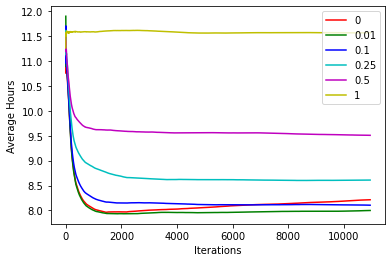

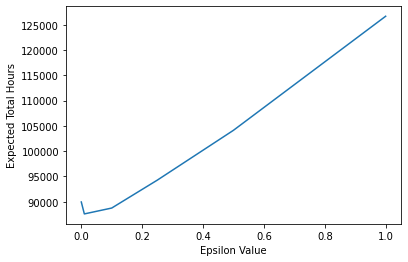

In [118]:
accountants = [(9, 4),
              (12, 1),
              (15, 5),
              (9, 2),
              (10, 0),
              (8, 3),
              (13, 4)]

# Driver code for plotting
def plot_epsilons(accountants, iterations, epsilons, bandit=multi_armed_bandit, episodes=300, colors=['r', 'g', 'b', 'c', 'm', 'y']):
    all_avg_hours = [0] * len(epsilons)
    total_hours_by_e = []
    for i, e in enumerate(epsilons):
        avg_epsilon_hours = []
        total_epsilon_hours = []
        for _ in range(episodes):
            avg_e, total_e =  bandit(accountants, iterations, e, alpha=0.1, q_1=-5)
            avg_epsilon_hours.append(np.array(avg_e))
            total_epsilon_hours.append(total_e)
        
        # Average over all the episodes
        for avg_e_hour in avg_epsilon_hours:
            all_avg_hours[i] += avg_e_hour
        all_avg_hours[i] /= episodes
        total_hours_by_e.append(sum(total_epsilon_hours) / episodes)
    
    for i, avg_hour in enumerate(all_avg_hours):
        plt.plot(avg_hour, color=colors[i], label=str(epsilons[i]))
    plt.xlabel("Iterations")
    plt.ylabel("Average Hours")
    plt.legend()
    plt.show()
        
    plt.plot(epsilons, total_hours_by_e)
    plt.xlabel("Epsilon Value")
    plt.ylabel("Expected Total Hours")
    plt.show()
    
    return all_avg_hours, total_hours_by_e
            
iterations = 10950
epsilons = [0, 0.01, 0.1, 0.25, 0.5, 1]
avg_e, total_e = plot_epsilons(accountants, iterations, epsilons)



# Task 2

Dynamic Programming using Iterative Policy Evaluation

In [12]:
def level2(level, mms, pmm):
    # value function height, width, action space
    v_func = np.zeros((len(level), len(level[0])))
    delta = 1
    theta = 0.00000000001
    iterations = 0
    
    while(delta >= theta):
        delta = 0.0
        for row in range(len(level[0]) - 1, 0, -1):
            for col in range(len(level) - 1):
                if level[col][row] == 2:
                    continue
                    
                # goal
                if col == 1 and row == 30:
                    continue
                
                v = v_func[col][row]
                      
                values = []
                energies = []
                
                # find values and energy for all next states
                for a in [0, 1, 2]:
                    (nx, ny), e = next_state(row, col, a, level)
                    values.append(v_func[ny, nx] + e)
                    energies.append(e)
                      
                expected = max(values)
                energy = energies[values.index(expected)]
                
                # check if an mm is at the position
                for (my, mx, _) in mms:
                    if col == my and row == mx:
                        # update the value based on p of going back to start
                        expected = (1 - pmm) * expected + pmm * (v_func[30, 1] + energy)
                    
                v_func[col, row] = expected
                delta = max(delta, abs(v - v_func[col, row]))
                
        iterations += 1
                      
    return v_func, iterations

In [13]:
def level2_path_finder(vf, level):
    x, y = (1, 30)
    path_x = [x]
    path_y = [y]
    
    while not(x == 30 and y == 1):
        states = []
        values = []
        for a in [0, 1, 2]:
            (nx, ny), _ = next_state(x, y, a, level)
            states.append((nx, ny))
            values.append(vf[ny, nx])
            
        x, y = states[values.index(max(values))]
        path_x.append(x)
        path_y.append(y)
    return path_x, path_y
        

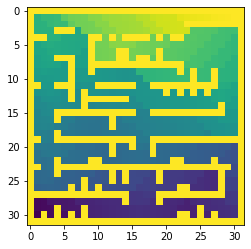

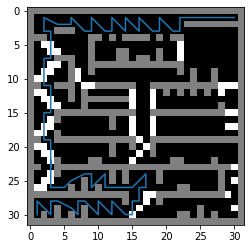

398


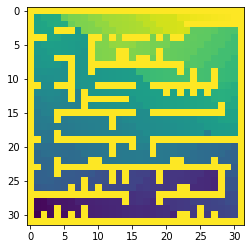

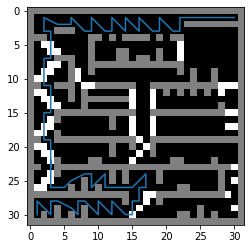

484


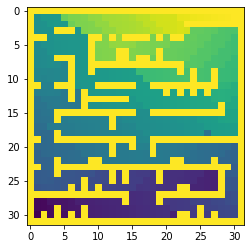

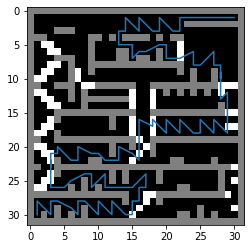

226


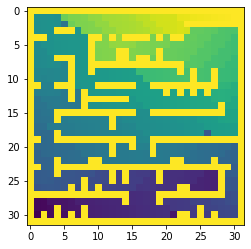

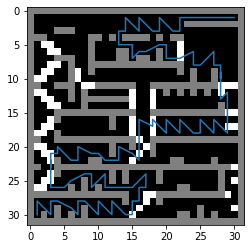

225


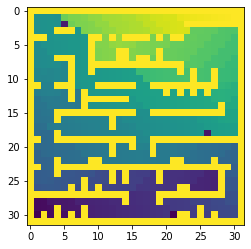

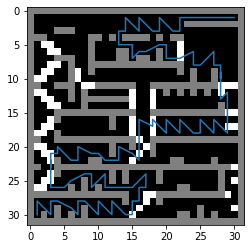

225


In [92]:
for pmm in [0.1, 0.2, 0.3, 0.5, 0.9]:
    level2_vf, level2_iters = level2(maps[0], enemies[0], pmm)
    path_x, path_y = level2_path_finder(level2_vf, maps[0])
    plt.imshow(level2_vf)
    plt.show()
    plt.imshow(maps[0], cmap="gray")
    plt.plot(path_x, path_y)
    plt.show()
    print(level2_iters)

# Task 3

In [14]:
# Sarsa for estimating Q approximately q
def level3_1step_sarsa(enemies, level=maps[1], episodes=20000, alpha=0.3, epsilon=0.1, max_steps=100000):
    Q = {} # x, y (+ mms if close)
    
    path_xs = []
    path_ys = []
    total_energy = 0
    
    mms = [(y, x) for y, x, _ in enemies]
    
    for e in tqdm(range(episodes)):
        x, y = (1, 30) # S
        mms = init_enemies(mms, level) # x coordinate of mm
        s = str(x) + " " + str(y)
        if not s in Q:
            Q[s] = [0.0, 0.0, 0.0]
        a = select_dictionary_action(Q, s, epsilon) # A
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            R = 0
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), energy = next_state(x, y, a, level)
            nmms = mms_next_state(mms , level)
            
            # find path of hubert this timestep
            intersections = find_intersects(x, y, nx, ny)
            for (ix, iy) in intersections:
                for mmy, mmx in nmms:
                    if ix == mmx and iy == mmy:
                        nx, ny = (1, 30) # back to start
                        break
            
            ns = str(nx) + " " + str(ny)
            
            # the space where mm location is relevant
            for mmy, mmx in nmms:
                if -1 < mmy - ny < 4:
                    ns += " " + str(mmx)
                
            if not ns in Q:
                Q[ns] = [0.0, 0.0, 0.0]
            
            # are we in the terminal state?
            if nx == 30 and ny == 1:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
                break
            
            R = energy
            
            # Choose action A'    
            na = select_dictionary_action(Q, ns, epsilon)
            
            # Update X, S and A
            Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
            x, y, mms, s, a = (nx, ny, nmms, ns, na)
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        total_energy = current_energy
    
    return Q, path_xs, path_ys, total_energy

In [15]:
level_3Q, level3_path_xs, level3_path_ys, level3_te = level3_1step_sarsa(enemies[1], level=maps[1], episodes=50000, epsilon=0)



100%|██████████| 50000/50000 [07:16<00:00, 114.59it/s]


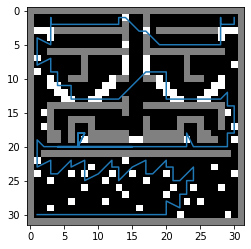

524


<ipython-input-17-05b90564f4d6>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("./plots" + str(i) + ".png")


FileNotFoundError: No such file: '/Users/bendiksolevag/Documents/krisskross/RLproject/Final Project/plots0.png'

In [17]:
plt.imshow(maps[1], cmap="gray")
plt.plot(level3_path_xs, level3_path_ys)
plt.show()
print(level3_te)

#for i in range(len(level3_path_xs)):
#    plt.imshow(maps[1], cmap="gray")
#    plt.scatter(level3_path_xs[i], level3_path_ys[i])
    plt.savefig("./plots/" + str(i) + ".png")
    plt.close()
    
with imageio.get_writer('./plots/level3.gif', mode="I") as writer:
    for i in range(len(level3_path_xs)):
        image = imageio.imread("./plots/" + str(i) + ".png")
        writer.append_data(image)
        os.remove("./plots/" + str(i) + ".png")

# Level 4

Dictionary State Space using only the local features of the window 

In [128]:
# Sarsa for estimating Q approximately q
def level4_TD(enemies, radius, episodes=20000, alpha=0.1, epsilon=0.1, level=maps[2], max_steps=10000000):
    Q = {} # x, y, fans
    
    path_xs = []
    path_ys = []
    total_energy = 0
    total_collisions = []
    
    fans = [(y, x) for y, x, _ in enemies]
    
    for e in tqdm(range(episodes)):
        x, y = (1, 30) # S
        # fans
        fans = init_enemies(fans, level)
                
        fans_seen = enemies_in_view(x, y, radius, fans)
        s = str(x) + " " + str(y) + " " + fans_seen
        if not s in Q:
            Q[s] = [0.0, 0.0, 0.0]
            
        a = select_dictionary_action(Q, s, epsilon) # A
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        collisions = []
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            R = 0    
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), energy = next_state(x, y, a, level)
            # new fan locations
            nfans = fans_next_state(fans, nx, ny, level)
            fans_seen = enemies_in_view(nx, ny, radius, nfans)
            ns = str(nx) + " " + str(ny) + str(fans_seen)
            if not ns in Q:
                Q[ns] = [0.0, 0.0, 0.0]
            
            # have they intersected?
            # find path of hubert this timestep
            intersections = find_intersects(x, y, nx, ny)
            
            for (ix, iy) in intersections:
                for nfy, nfx in nfans:
                    if ix == nfx and iy == nfy:
                        R -=  np.random.uniform(20, 100)# back to start
                        collisions.append((nfx, nfy))
            
            # are we in the terminal state?
            if nx == 30 and ny == 1:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
                break
            
            R += energy
            
            # Choose action A'    
            na = select_dictionary_action(Q, ns, epsilon)
            
            # Update X, S and A
            Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
            x, y, s, a, fans = (nx, ny, ns, na, nfans)
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        total_energy = current_energy
        total_collisions.append(len(collisions))
    
    return Q, path_xs, path_ys, total_energy, total_collisions



In [131]:
level_4Q, level4_path_xs, level4_path_ys, te, total_collisions = level4_TD(enemies[2], 4, episodes=50000, epsilon=0)


100%|███████████████████████████████████████████████████████████████████████████████| 50000/50000 [05:39<00:00, 147.34it/s]


In [ ]:
plt.plot(total_collisions)
plt.show()
print(len(level4_path_xs), te, total_collisions[-1])

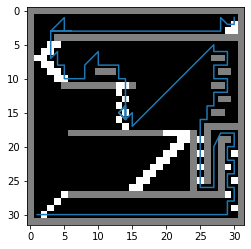

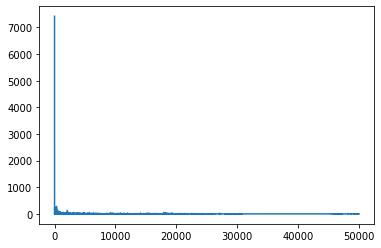

140 355.68399766571906 1


In [132]:
for i in range(len(level4_path_xs)):
    plt.imshow(maps[2], cmap="gray")
    plt.scatter(level4_path_xs[i], level4_path_ys[i])
    plt.savefig("./plots/" + str(i) + ".png")
    plt.close()
    
with imageio.get_writer('./plots/level4.gif', mode="I") as writer:
    for i in range(len(level4_path_xs)):
        image = imageio.imread("./plots" + str(i) + ".png")
        writer.append_data(image)
        os.remove("./plots/" + str(i) + ".png")


# Level 5

Solve using both Q-learning tabularly and then solve using Function Approximation

In [69]:
def get_local_features(x, y, r, level):
    features = []
    for dy in range(-r, r + 1):
        for dx in range(-r, r + 1):
            features.append(level[y+dy][x+dx])
    return features

In [70]:
def pad_level(l, r):
    level = [[2 for _ in range(len(l[0]) + 2 * r)] for _ in range(len(l) + 2 * r)]
    for y in range(len(l)):
        for x in range(len(l[0])):
            level[y + r][x + r] = l[y][x]
    
    return level


Solution using action-value function

In [76]:
# Sarsa for estimating Q approximately q
def level5_TD(radius, level=maps[3], episodes=20000, alpha=0.1, epsilon=0.1, max_steps=100000):
    Q = {} # local feature window
    
    path_xs = []
    path_ys = []
    best_energy = float("inf")
    final_energy = 0
    
    level = pad_level(level, radius)
    
    for e in tqdm(range(episodes)):
        x, y = (1 + radius, 30 + radius) # S
        s = "-".join(str(_) for _ in get_local_features(x, y, radius, level))
        if not s in Q:
            Q[s] = [0.0, 0.0, 0.0]
            
        a = select_dictionary_action(Q, s, epsilon) # A
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            R = 0    
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), energy = level5_next_state(x, y, a, level)
            ns = "-".join(str(_) for _ in get_local_features(nx, ny, radius, level))
            if not ns in Q:
                Q[ns] = [0.0, 0.0, 0.0]
            
            # are we in the terminal state?
            if nx == 30 + radius and ny == 1 + radius:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
                break
            
            R = energy
            
            # Choose action A'    
            na = select_dictionary_action(Q, ns, epsilon)
            
            # Update X, S and A
            Q[s][a] = Q[s][a] + alpha * (R + Q[ns][na] - Q[s][a])
            x, y, s, a = (nx, ny, ns, na)
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        final_energy = current_energy
    
    return Q, path_xs, path_ys, final_energy



In [77]:
l5Q_td, l5_path_xs_td, l5_path_ys, l5td_te = level5_TD(4, epsilon=0)


100%|███████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:46<00:00, 428.66it/s]


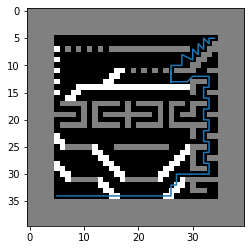

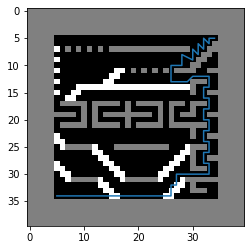

79 162


In [75]:
for i in range(len(level5_path_xs_tf)):
    plt.imshow(maps[3], cmap="gray")
    plt.scatter(level5_path_xs[i], level5_path_xs_td[i])
    plt.savefig("./plots/" + str(i) + ".png")
    plt.close()
    
with imageio.get_writer('./plots/level5.gif', mode="I") as writer:
    for i in range(len(level5_path_xs)):
        image = imageio.imread("./plots" + str(i) + ".png")
        writer.append_data(image)
        os.remove("./plots/" + str(i) + ".png")

Solution using PyTorch and function approximation

In [19]:
class Policy(nn.Module):
    """PyTorch solution for policy gradient,
    input """
    def __init__(self, local_window=9):
        super().__init__()
        
        self.fc1 = nn.Linear(local_window**2 + 1, 32)
        self.fc2 = nn.Linear(32, 3)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = self.softmax(self.fc2(out))
        return out


In [20]:
def select_policy_action(policy, s, epsilon=0.1):
    s_tensor = torch.tensor(s).type(torch.FloatTensor)
    a_value = policy(s_tensor)
    a = torch.argmax(a_value)
    # explorative move
    if random.random() < epsilon:
        return random.randrange(0, 3), a_value
    # exploitative move
    return a, a_value

In [116]:
# Semi-gradient Sarsa with function approximation using neural network
def level5_func_approx(radius, episodes=20000, gamma=0.99, epsilon=0.01, max_steps=100000):
    
    policy = Policy(radius * 2 + 1)
    optimizer = optim.Adam(policy.parameters(), lr=0.001)
    gamma = 1.0
    
    path_xs = []
    path_ys = []
    total_energy = 0
    
    # fix to be parameter
    level = pad_level(maps[3], radius)
    
    for e in tqdm(range(episodes)):
        x, y = (1 + radius, 30 + radius) # S
        s = get_local_features(x, y, radius, level) + [0]
        
        # select action from policy
        a, a_v = select_policy_action(policy, s, epsilon)
        
        # for trajectory plotting
        xs = []
        ys = []
        current_energy = 0
        
        # time steps
        for _ in range(max_steps):
            xs.append(x)
            ys.append(y)
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), R = level5_next_state(x, y, a, level)
            
            # are we in the terminal state?
            if nx == 30 + radius and ny == 1 + radius:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                final_loss = torch.tensor(-(R - a_v[a]), requires_grad=True)
                final_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                break
            
            # Choose action A' as a function of  q(S', *, w)
            ns = get_local_features(nx, ny, radius, level) + [a]
            na, na_v = select_policy_action(policy, ns, epsilon)
            
            # Update X, S and A
            loss = -(R + gamma * na_v[na] - a_v[a])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            x, y, s, a, a_v = (nx, ny, ns, na, na_v.detach())
            current_energy -= R
            
        path_xs = xs
        path_ys = ys
        total_energy = current_energy
        
        if e % 20 == 0:
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()
    
    return path_xs, path_ys, total_energy



In [ ]:
level5_path_xs, level5_path_ys, level5_te = level5_func_approx(4, episodes=200, epsilon=0.1)


# Level 6

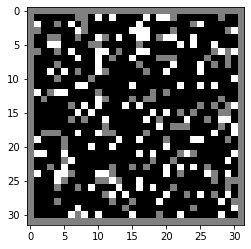

In [64]:
def create_custom_map(x, y):
    custom_map = [[2] + [1 for _ in range(x-2)] + [2] for _ in range(y)]
    custom_map[0] = [2 for _ in range(x)]
    custom_map[31] = [2 for _ in range(x)]
    for i in range(1, 31):
        for j in range(1, 31):
            custom_map[i][j] = np.random.choice([1, 1, 1, 1, 1, 1, 2, 3])
    custom_map[y-2][x//2] = 1
    return custom_map

plt.imshow(create_custom_map(32, 32), cmap="gray")
plt.show()

In [21]:
class Sarsa_Policy(nn.Module):
    """PyTorch solution for function approximation,
    input """
    def __init__(self, local_window=9):
        super().__init__()
        
        self.fc1 = nn.Linear(local_window**2 + 1, 32)
        self.fc2 = nn.Linear(32, 3)
        
    def forward(self, x):
        out = torch.relu(self.fc1(x))
        out = self.fc2(out)
        return out


In [67]:
#Semi-gradient Sarsa with function approximation using neural network
def level6_sarsa(enemies, radius, level, n=1, e0=0, dE=0, episodes=5000, gamma=0.99, epsilon=0.05):
    
    policy = Sarsa_Policy(radius * 2 + 1)
    optimizer = optim.Adam(policy.parameters(), lr=0.0001)
    
    path_xs = []
    path_ys = []
    y_peak_total = len(level)+radius
    
    # fix to be parameter
    level = pad_level(level, radius)
    
    for e in tqdm(range(episodes)):
        stored_A = {}
        stored_R = {}
        stored_S = {}
        stored_Q = {}
        
        x, y = (len(level[0]) // 2, len(level) - radius - 2) # S
        s = get_local_features(x, y, radius, level) + [0] # last a => left
        energy_budget = e0
        y_peak = len(level)+radius
        
        # select action from policy
        a, q = select_policy_action(policy, s, epsilon)
        
        stored_A[0] = a
        stored_S[0] = s
        stored_Q[0] = q
        
        # for trajectory plotting
        xs = []
        ys = []
        
        # Reward Shaping
        last_pos = [(x, y)] # exploration
        last_5_ys = [y for _ in range(5)]
        
        t = -1
        T = sys.maxsize
        tau = 0
        while tau < (T - 1):
            xs.append(x)
            ys.append(y)
            
            t += 1
            current = (t+1) % (n+1)
            
            if t < T:
                # Observe R, S'. S' described as = n+value (for new)
                R = 0
                (nx, ny), energy = level5_next_state(x, y, a, level)
                energy_budget += energy
                R += energy
            
                # ways to hand out reward
                if y < y_peak:
                    y_peak = ny
                    energy_budget += dE
                    R += dE
                    
                if (nx, ny) not in last_pos:
                    R += 3
                    last_pos.append((nx, ny))
                    
                if ny > np.mean(last_5_ys):
                    R += -10
                    
                last_5_ys.pop(0)
                last_5_ys.append(ny)
                    
                stored_R[current] = R
                stored_S[current] = (x, y)
                
                # are we in the terminal state?
                if energy_budget < 0:
                    T = t + 1
                else:
                    # Choose action A' as a function of  q(S', w)
                    ns = get_local_features(nx, ny, radius, level) + [a]
                    na, nq = select_policy_action(policy, ns, epsilon)
                    stored_S[current] = ns
                    stored_A[current] = na
                    stored_Q[current] = nq.detach()

            tau = t - n + 1
            if tau >= 0:
                G = np.sum([stored_R[i%(n+1)] for i in range(tau+1, min(tau+n, T))])
                
                if tau + n < T:
                    G += stored_Q[tau % (n+1)][stored_A[tau % (n+1)]]
                    
                loss = -(G - gamma * stored_Q[tau % (n+1)][stored_A[tau % (n+1)]].clone().detach().requires_grad_(True))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
            x, y, a = (nx, ny, na)
                
            
        path_xs = xs
        path_ys = ys
        
        if y_peak - radius < y_peak_total:
            y_peak_total = y_peak - radius
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()
        
        if e % 400 == 0:
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()
    
    return policy, y_peak_total, path_xs, path_ys


  0%|                                                                                             | 0/2000 [00:00<?, ?it/s]

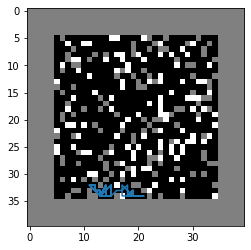

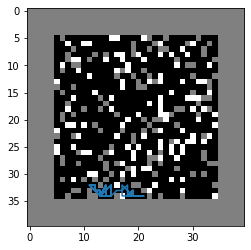

  0%|▏                                                                                    | 3/2000 [00:00<04:34,  7.28it/s]

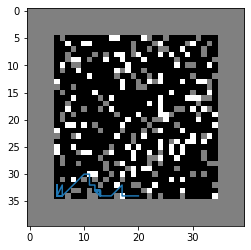

 20%|████████████████▌                                                                  | 399/2000 [00:35<02:27, 10.84it/s]

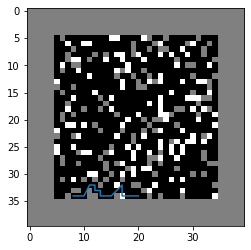

 34%|████████████████████████████▎                                                      | 681/2000 [01:01<01:55, 11.43it/s]

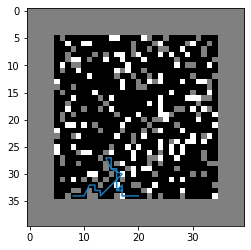

 40%|█████████████████████████████████▏                                                 | 799/2000 [01:12<01:53, 10.63it/s]

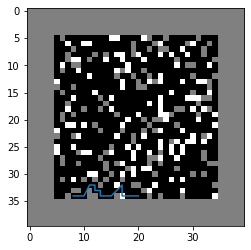

 60%|█████████████████████████████████████████████████▏                                | 1199/2000 [01:48<01:12, 11.04it/s]

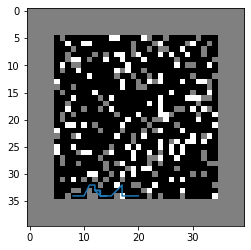

 80%|█████████████████████████████████████████████████████████████████▌                | 1599/2000 [02:25<00:38, 10.42it/s]

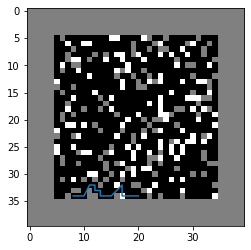

100%|██████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:02<00:00, 10.95it/s]

23 0


In [138]:
slevel6_policy, slevel_6_peak, speaks, slevel6_path_xs, slevel6_path_ys = level6_sarsa(None, 4, create_custom_map(32, 32), 5, e0=400, dE=50, episodes=2000)
print(slevel_6_peak, speaks)


In [ ]:
# Semi-gradient Sarsa with function approximation using neural network
def step1_level6(enemies, radius, level, e0=0, dE=0, episodes=2000, gamma=0.99, epsilon=0.05):
    
    policy = Sarsa_Policy(radius * 2 + 1)        
    
    optimizer = optim.Adam(policy.parameters(), lr=0.001)
    gamma = 1.0
    
    path_xs = []
    path_ys = []
    y_peak_total = len(level)+radius
    
    # fix to be parameter
    level = pad_level(level, radius)
    
    for e in tqdm(range(episodes)):
        x, y = (len(level[0]) // 2, len(level) - radius - 2) # S
        s = get_local_features(x, y, radius, level) + [0]
        energy_budget = e0
        y_peak = len(level)+radius
        
        # select action from policy
        a, value_a = select_policy_action(policy, s, epsilon)
        
        # for trajectory plotting
        xs = []
        ys = []
        
        # testing for different rewards
        last_pos = [(x, y)]
        last_ys = [len(level) for _ in range(5)]
        
        while True:
            xs.append(x)
            ys.append(y)
            
            # Observe R, S'. S' described as = n+value (for new)
            (nx, ny), energy = level5_next_state(x, y, a, level)
            energy_budget += energy
            R = energy
            
            # ways to hand out reward
            if ny < y_peak:
                y_peak = ny
                energy_budget += dE
                R += dE
            
            # Rewards exploration
            if (nx, ny) not in last_pos:
                last_pos.append((nx, ny))
                R += 3
                
            if ny > np.mean(last_ys):
                R += -5
            
            last_ys.pop(0)
            last_ys.append(ny)
                
            # are we in the terminal state?
            if energy_budget < 0:
                xs.append(nx)
                ys.append(ny)
                # Only update when completed!
                final_loss = -(R - value_a[a].clone().detach().requires_grad_(True))
                final_loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                break
            
            # Choose action A' as a function of  q(S', w)
            ns = get_local_features(nx, ny, radius, level) + [a]
            na, value_na = select_policy_action(policy, ns, epsilon)
            
            # Update X, S and A
            loss = -(R + gamma * value_na[na] - value_a[a])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            x, y, s, a, value_a = (nx, ny, ns, na, value_na.detach())
            
            
        path_xs = xs
        path_ys = ys
        
        if y_peak - radius < y_peak_total:
            y_peak_total = y_peak - radius
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()
        
        if e % 400 == 0:
            plt.imshow(level, cmap="gray")
            plt.plot(path_xs, path_ys)
            plt.show()

            
    return policy, y_peak_total, path_xs, path_ys

  0%|                                                                                            | 0/10000 [00:00<?, ?it/s]

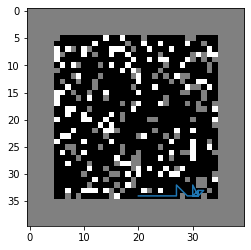

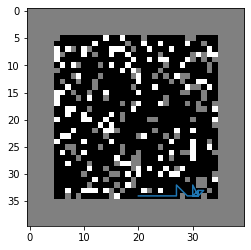

  0%|▏                                                                                  | 19/10000 [00:00<02:32, 65.29it/s]

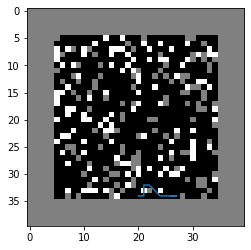

  4%|███▏                                                                              | 396/10000 [00:04<01:40, 95.46it/s]

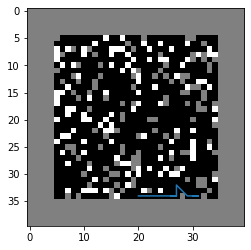

  8%|██████▏                                                                           | 751/10000 [00:08<01:41, 91.35it/s]

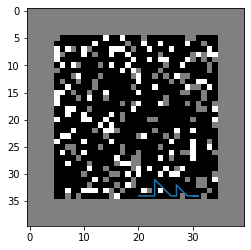

  8%|██████▍                                                                           | 792/10000 [00:08<01:39, 92.89it/s]

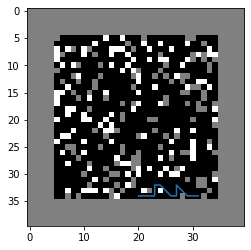

 12%|█████████▋                                                                       | 1196/10000 [00:13<01:31, 96.52it/s]

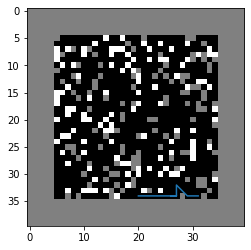

 13%|██████████▋                                                                      | 1317/10000 [00:14<01:32, 93.89it/s]

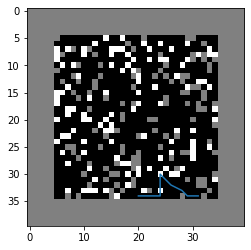

 16%|████████████▉                                                                    | 1594/10000 [00:17<01:29, 94.31it/s]

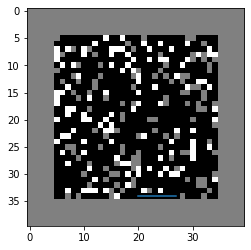

 20%|████████████████▏                                                                | 1996/10000 [00:21<01:26, 92.02it/s]

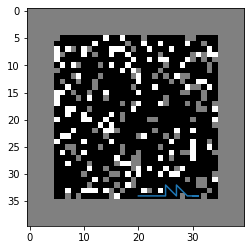

 24%|███████████████████▍                                                             | 2398/10000 [00:26<01:19, 95.83it/s]

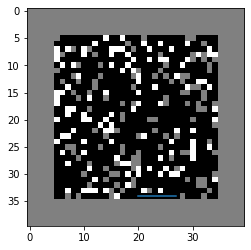

 28%|██████████████████████▋                                                          | 2795/10000 [00:30<01:16, 94.12it/s]

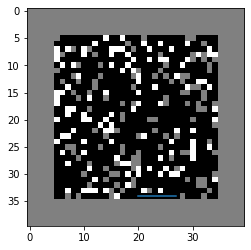

 32%|█████████████████████████▊                                                       | 3193/10000 [00:34<01:11, 95.60it/s]

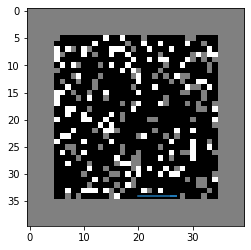

 36%|█████████████████████████████▏                                                   | 3598/10000 [00:39<01:05, 97.98it/s]

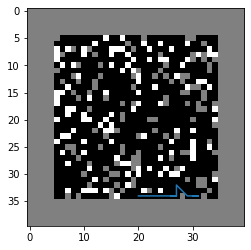

 40%|████████████████████████████████▍                                                | 4000/10000 [00:43<01:03, 94.49it/s]

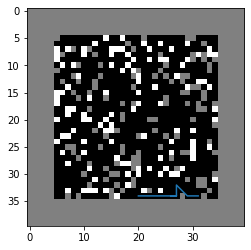

 44%|███████████████████████████████████▌                                             | 4397/10000 [00:47<01:01, 91.43it/s]

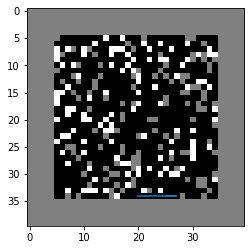

 45%|████████████████████████████████████▌                                            | 4519/10000 [00:49<00:59, 92.18it/s]


KeyboardInterrupt: 

In [66]:
slevel6_policy, slevel_6_peak, slevel6_path_xs, slevel6_path_ys = level6_sarsa(None, 4, create_custom_map(32, 32), e0=40, dE=15, episodes=10000)
print(slevel_6_peak)
